In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
from warnings import filterwarnings,simplefilter
import time
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split,cross_val_score,KFold,StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

In [2]:
train = pd.read_csv('train.csv')
camp_data = pd.read_csv('campaign_data.csv')
trans_data = pd.read_csv('customer_transaction_data.csv')
item_data = pd.read_csv('item_data.csv')
c_info = pd.read_csv('customer_demographics.csv')
coupon_item_map = pd.read_csv('coupon_item_mapping.csv')
test = pd.read_csv('test.csv')
pd.set_option('display.max_columns',400)

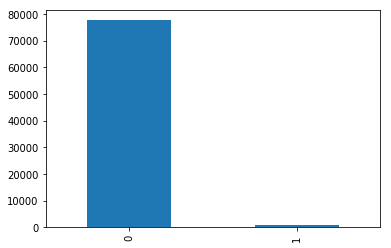

In [3]:
train.redemption_status.value_counts().plot.bar()

In [4]:
#check=train[(train.campaign_id==11)|(train.campaign_id==12)|(train.campaign_id==26)|(train.campaign_id==27)]
#train=train[~((train.campaign_id==11)|(train.campaign_id==12)|(train.campaign_id==26)|(train.campaign_id==27))]

In [5]:
def camp_count_cut(df,bins,labels):
    df['campaign_count'] = df['campaign_id'].map(df.campaign_id.value_counts())
    df['campaign_count']=pd.cut(df['campaign_count'],bins=bins,labels=labels)
    df['campaign_count'] = df['campaign_count'].astype('str')
    return df
bins=[-1,500,1000,1500,2000,3000,4000,5000,5500,7000,24000]
labels=['<0.5k','0.5-1k','1-1.5k','1.5-2k','2-3k','3-4k','4-5k','5-5.5k','5.5-7k','>7k']
train=camp_count_cut(train,bins,labels)
test=camp_count_cut(test,bins,labels)
#check=camp_count_cut(check,bins,labels)

In [6]:
def coup_count_cut(df,bins,labels):
    df['coupon_count'] = df['coupon_id'].map(df.coupon_id.value_counts())
    df['coupon_count']=pd.cut(df['coupon_count'],bins=bins,labels=labels)
    df['coupon_count'] = df['coupon_count'].astype('str')
    return df
bins=np.int64(np.linspace(10,580,30))
labels=['coup_count'+str(i) for i in range(29)]
train=coup_count_cut(train,bins,labels)
test=coup_count_cut(test,bins,labels)
#check=coup_count_cut(check,bins,labels)

In [7]:
def cust_count_cut(df,bins,labels):
    df['customer_count'] = df['customer_id'].map(df.customer_id.value_counts())
    df['customer_count']=pd.cut(df['customer_count'],bins=bins,labels=labels)
    df['customer_count'] = df['customer_count'].astype('str')
    return df
bins=np.int64(np.linspace(7,168,30))
labels=['cust_count'+str(i) for i in range(29)]
train=cust_count_cut(train,bins,labels)
test=cust_count_cut(test,bins,labels)
#check=cust_count_cut(check,bins,labels)

In [8]:
for i in camp_data.index:
    m2 = int(camp_data['end_date'][i].split('/')[1])
    m1 = int(camp_data['start_date'][i].split('/')[1])
    camp_data.loc[i,'campaign_length'] = (m2 - m1)
camp_data['campaign_length'] = camp_data['campaign_length'].astype('int64')
camp_data['campaign_length'] = camp_data['campaign_length'].replace([-10,-11],[2,1])
camp_data['len_type']  = camp_data['campaign_type'] + camp_data['campaign_length'].astype('str')
camp_data

,campaign_id,campaign_type,start_date,end_date,campaign_length,len_type
0,24,Y,21/10/13,20/12/13,2,Y2
1,25,Y,21/10/13,22/11/13,1,Y1
2,20,Y,07/09/13,16/11/13,2,Y2
3,23,Y,08/10/13,15/11/13,1,Y1
4,21,Y,16/09/13,18/10/13,1,Y1
5,22,X,16/09/13,18/10/13,1,X1
6,18,X,10/08/13,04/10/13,2,X2
7,19,Y,26/08/13,27/09/13,1,Y1
8,17,Y,29/07/13,30/08/13,1,Y1
9,16,Y,15/07/13,16/08/13,1,Y1


In [9]:
test.head()

,id,campaign_id,coupon_id,customer_id,campaign_count,coupon_count,customer_count
0,3,22,869,967,5.5-7k,coup_count28,cust_count10
1,4,20,389,1566,5.5-7k,coup_count11,cust_count18
2,5,22,981,510,5.5-7k,coup_count23,cust_count14
3,8,25,1069,361,3-4k,coup_count19,cust_count1
4,10,17,498,811,3-4k,coup_count9,cust_count11


In [10]:
for i in ['customer_id','coupon_id','campaign_id']:
    x=list(set(train[i].unique()).intersection(test[i].unique()))
    print('common ' +str(i) + ': {}' .format(len(x)),
          'test '+str(i) + ': {}' .format(test[i].unique().shape[0]))

common customer_id: 1096 test customer_id: 1250
common coupon_id: 81 test coupon_id: 331
common campaign_id: 0 test campaign_id: 10


C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `item` has been deprecated and will be removed in a future version
  import sys


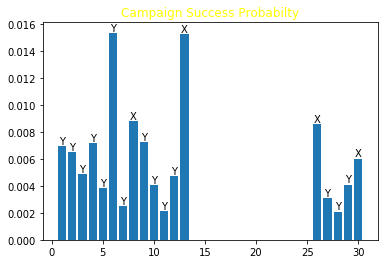

In [11]:
camp_table_prob = train.pivot_table(index='campaign_id',values='redemption_status').sort_values('redemption_status')
#bar = camp_table_prob.sort_values('redemption_status').plot.bar()  
bar1 = plt.bar(x=camp_table_prob.index,height=camp_table_prob.redemption_status)
plt.title('Campaign Success Probabilty',color='yellow')
for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%s' % camp_data[camp_data.campaign_id==int(rect.get_x()+1)].campaign_type.item() , ha='center', va='bottom')
    #print(camp_data[camp_data.campaign_id==int(rect.get_x()+1)].campaign_type)
plt.show()


In [12]:
train_df = pd.merge(train,camp_data,on='campaign_id',how='left')
test_df = pd.merge(test,camp_data,on='campaign_id',how='left')
#check_df = pd.merge(check,camp_data,on='campaign_id',how='left')

In [13]:
train_df.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,campaign_count,coupon_count,customer_count,campaign_type,start_date,end_date,campaign_length,len_type
0,1,13,27,1053,0,>7k,coup_count5,cust_count4,X,19/05/13,05/07/13,2,X2
1,2,13,116,48,0,>7k,coup_count4,cust_count1,X,19/05/13,05/07/13,2,X2
2,6,9,635,205,0,3-4k,coup_count8,cust_count12,Y,11/03/13,12/04/13,1,Y1
3,7,13,644,1050,0,>7k,coup_count5,cust_count8,X,19/05/13,05/07/13,2,X2
4,9,8,1017,1489,0,>7k,coup_count5,cust_count7,X,16/02/13,05/04/13,2,X2


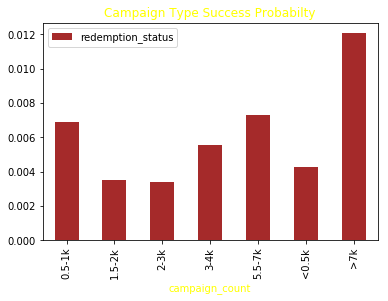

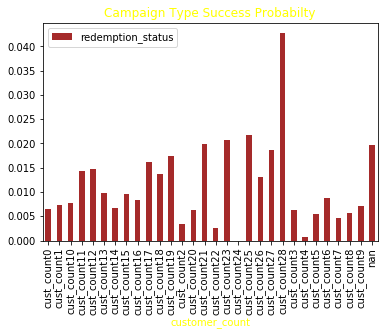

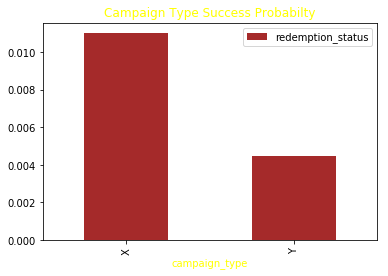

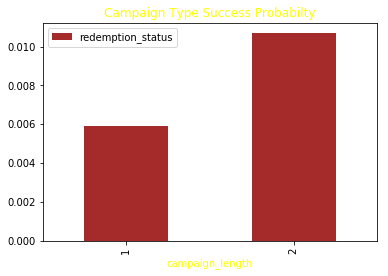

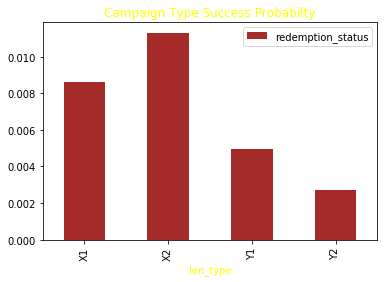

In [14]:
for i in ['campaign_count','customer_count','campaign_type','campaign_length','len_type']:
    train_df.pivot_table(index=i,values='redemption_status').plot.bar(color='brown')
    plt.title('Campaign Type Success Probabilty',color='yellow')
    plt.xlabel(i,color='yellow')
plt.show()

## Filling Customer Info

In [15]:
filterwarnings('ignore')
#filling children NaNs
c_info.loc[c_info.no_of_children=='3+','no_of_children'] = 3
c_info.loc[c_info.family_size=='5+','family_size'] = 5
c_info.loc[c_info.no_of_children.isna(),'no_of_children'] = 0

#filling marital_status NaNs
c_info.loc[(c_info.marital_status.isna()) & (c_info.family_size=='1'),'marital_status']='Single'
x = (c_info.family_size.astype(int)) - (c_info.no_of_children.astype(int))
c_info.loc[(c_info.marital_status.isna()) & (x==2),'marital_status'] = 'Married'
c_info.loc[c_info.marital_status.isna(),'marital_status'] = 'Single'

for i in ['family_size','no_of_children']:
    c_info[i]=c_info[i].astype('int64')
#additonal_info
c_info['income_bracket_pp'] = (c_info['income_bracket']/c_info['family_size']).round(1)
c_info['no_of_adults'] = c_info['family_size'] - c_info['no_of_children']

In [16]:
c_info
def merge_cust_info(df):
    df = pd.merge( df ,c_info, on='customer_id', how='left')
    df.fillna(df.max(),inplace=True)
    return df
train_df = merge_cust_info(train_df)
#check_df = merge_cust_info(check_df)
test_df = merge_cust_info(test_df)

In [17]:
train_df.customer_id.unique().shape,c_info.customer_id.shape,trans_data.customer_id.unique().shape

((1428,), (760,), (1582,))

In [18]:
trans_data.item_id.unique().shape,coupon_item_map.item_id.unique().shape,item_data.item_id.unique().shape

((74063,), (36289,), (74066,))

In [19]:
item_data.head()

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


In [20]:
import datetime
trans_data = trans_data.drop_duplicates(keep='first')
trans_data['date'] = pd.to_datetime(trans_data.date)
trans_data['month'] =np.int64(trans_data['date'].dt.strftime('%m'))

trans_data_item = pd.merge(trans_data,item_data,on='item_id',how='left')
trans_data_item = trans_data_item[~((trans_data_item.category== 'Miscellaneous')|(trans_data_item.category== 'Fuel'))]

#trans_data_item.loc[trans_data_item.selling_price>500,'selling_price'] = 500
#trans_data_item.loc[trans_data_item.other_discount<-150,'other_discount'] = -150
#trans_data_item.loc[trans_data_item.coupon_discount<-20,'coupon_discount'] = -20

In [21]:
coupon_item_merge = pd.merge(coupon_item_map,item_data, on='item_id',how='left')
coupon_item_merge.head()

,coupon_id,item_id,brand,brand_type,category
0,105,37,56,Local,Grocery
1,107,75,56,Local,Grocery
2,494,76,209,Established,Grocery
3,522,77,278,Established,Grocery
4,518,77,278,Established,Grocery


## Coupon Data

In [22]:
'''trans ---> item'''
per_item_df = trans_data_item.groupby(by='item_id').mean()
per_item_df_sum = trans_data.groupby(by='item_id').sum()
coupon_item_merge['quant_per_item'] = coupon_item_merge['item_id'].map(per_item_df['quantity'])
coupon_item_merge['disc_per_item'] = coupon_item_merge['item_id'].map(per_item_df['coupon_discount'])
coupon_item_merge['disc_per_item'] = np.abs(coupon_item_merge['disc_per_item'])

coupon_item_merge['sp_per_item'] = coupon_item_merge['item_id'].map(per_item_df['selling_price'])
coupon_item_merge['other_disc_per_item']=coupon_item_merge['item_id'].map(per_item_df['other_discount'])
coupon_item_merge['other_disc_per_item'] = np.abs(coupon_item_merge['other_disc_per_item'])

coupon_item_merge.loc[coupon_item_merge['disc_per_item']>0,'discount_taken_ever'] = 'Yes'
coupon_item_merge.loc[coupon_item_merge['disc_per_item']==0,'discount_taken_ever'] = 'No'

#mean#####################################
coupon_item_merge['sum_quant_per_item'] = coupon_item_merge['item_id'].map(per_item_df_sum['quantity'])
coupon_item_merge['sum_disc_per_item'] = coupon_item_merge['item_id'].map(per_item_df_sum['coupon_discount'])
coupon_item_merge['sum_disc_per_item'] = np.abs(coupon_item_merge['sum_disc_per_item'])

coupon_item_merge['sum_sp_per_item'] = coupon_item_merge['item_id'].map(per_item_df_sum['selling_price'])
coupon_item_merge['sum_other_disc_per_item']=coupon_item_merge['item_id'].map(per_item_df_sum['other_discount'])
coupon_item_merge['sum_other_disc_per_item'] = np.abs(coupon_item_merge['sum_other_disc_per_item'])

coupon_item_merge.loc[coupon_item_merge['sum_disc_per_item']>0,'sum_iscount_taken_ever'] = 'Yes'
coupon_item_merge.loc[coupon_item_merge['sum_disc_per_item']==0,'sum_discount_taken_ever'] = 'No'
###################################################

coupon_item_merge['avg_month'] = coupon_item_merge['item_id'].map(per_item_df['month'])
coupon_item_merge.fillna(coupon_item_merge.max(),inplace=True)
coupon_item_merge.fillna('Yes',inplace=True)
coupon_item_merge['avg_month'] = coupon_item_merge['avg_month'].astype('int')

'''item ---> coupon'''
per_coupon_df_max = coupon_item_merge.groupby('coupon_id').max()
per_coupon_df_mean = coupon_item_merge.groupby('coupon_id').mean()
per_coupon_df_sum = coupon_item_merge.groupby('coupon_id').sum()

'''coupon ---> train,test'''
def add_coup_data(df):
    for i in ['brand','brand_type','category','discount_taken_ever',
              'quant_per_item','disc_per_item','sp_per_item','other_disc_per_item','avg_month',
             'sum_quant_per_item','sum_disc_per_item','sum_sp_per_item','sum_other_disc_per_item']:
        df['max_'+str(i)+'_coup'] = df['coupon_id'].map(per_coupon_df_max[i])
        df['max_'+str(i)+'_coup'] = df['coupon_id'].map(per_coupon_df_max[i])
    for i in ['quant_per_item','disc_per_item','sp_per_item','other_disc_per_item','avg_month',]:
        df['mean_'+str(i)+'_coup'] = df['coupon_id'].map(per_coupon_df_mean[i])
        df['mean_'+str(i)+'_coup'] = df['coupon_id'].map(per_coupon_df_mean[i])
    df['mean_avg_month_coup'] = df['mean_avg_month_coup'].astype('int') 
    ####################################################################
    for i in ['sum_quant_per_item','sum_disc_per_item','sum_sp_per_item','sum_other_disc_per_item']:
        df['sum_'+str(i)+'_coup'] = df['coupon_id'].map(per_coupon_df_sum[i])
        df['sum_'+str(i)+'_coup'] = df['coupon_id'].map(per_coupon_df_sum[i])
    ######################################################################
add_coup_data(train_df)
add_coup_data(test_df)
#add_coup_data(check_df)

In [23]:
'''def sym(df):
    for i in ['mean_quant_per_item_coup','mean_disc_per_item_coup',
              'mean_sp_per_item_coup','mean_other_disc_per_item_coup']:
        for j in range(2):
            df[i] = np.sqrt(df[i])
sym(train_df)
sym(test_df)
#sym(check_df)'''

"def sym(df):\n    for i in ['mean_quant_per_item_coup','mean_disc_per_item_coup',\n              'mean_sp_per_item_coup','mean_other_disc_per_item_coup']:\n        for j in range(2):\n            df[i] = np.sqrt(df[i])\nsym(train_df)\nsym(test_df)\n#sym(check_df)"

In [24]:
'''for i in ['mean_quant_per_item_coup','mean_disc_per_item_coup','mean_sp_per_item_coup',
          'mean_other_disc_per_item_coup','mean_avg_month_coup']:
    train_df[i].plot.hist(color='brown')
    plt.xlabel(i,color='yellow')
    plt.show()'''

"for i in ['mean_quant_per_item_coup','mean_disc_per_item_coup','mean_sp_per_item_coup',\n          'mean_other_disc_per_item_coup','mean_avg_month_coup']:\n    train_df[i].plot.hist(color='brown')\n    plt.xlabel(i,color='yellow')\n    plt.show()"

## Customer Data

In [25]:
q = trans_data_item.groupby(by='customer_id').mean()
q_s = trans_data_item.groupby(by='customer_id').sum()
q1 = trans_data_item[trans_data_item.coupon_discount<1].groupby(by='customer_id').max()
#plt.scatter(np.abs(q.coupon_discount),q.quantity)
def merge_trans(df):
    df['cust_discount_availed'] = df['customer_id'].map(np.abs(q['coupon_discount']))
    df['cust_quant_bought'] = df['customer_id'].map(q['quantity'])

    df['cust_sp_per_item'] = df['customer_id'].map(q['selling_price'])
    df['cust_other_disc_per_item']= df['customer_id'].map(q['other_discount'])
    df['cust_other_disc_per_item'] = np.abs(df['cust_other_disc_per_item'])

    df.loc[df['cust_discount_availed']>0,'cust_discount_taken_ever'] = 'Yes'
    df.loc[df['cust_discount_availed']==0,'cust_discount_taken_ever'] = 'No'

    df['cust_avg_month'] = df['customer_id'].map(q['month']).astype('int')
    
    ##################################################################################3
    df['sum_cust_discount_availed'] = df['customer_id'].map(np.abs(q_s['coupon_discount']))
    df['sum_cust_quant_bought'] = df['customer_id'].map(q_s['quantity'])

    df['sum_cust_sp_per_item'] = df['customer_id'].map(q_s['selling_price'])
    df['sum_cust_other_disc_per_item']= df['customer_id'].map(q_s['other_discount'])
    df['sum_cust_other_disc_per_item'] = np.abs(df['sum_cust_other_disc_per_item'])

    df.loc[df['sum_cust_discount_availed']>0,'sum_cust_discount_taken_ever'] = 'Yes'
    df.loc[df['sum_cust_discount_availed']==0,'sum_cust_discount_taken_ever'] = 'No'
    ###########################################################3
    
    
    for i in ['brand','brand_type','category','coupon_discount','quantity',
               'selling_price','other_discount']:
        df['cust_most_disc_' + str(i) ] = df['customer_id'].map(q1[i])
    df.fillna(-999,inplace = True)
merge_trans(train_df)
merge_trans(test_df)
#merge_trans(check_df)

In [26]:
def sym1(df):
    for i in ['cust_discount_availed','cust_quant_bought',
              'cust_sp_per_item','cust_other_disc_per_item','cust_avg_month',
               'sum_cust_discount_availed','sum_cust_quant_bought',]:
        for j in range(1):
            df[i] = np.sqrt(df[i])
sym1(train_df)
sym1(test_df)
#sym1(check_df)

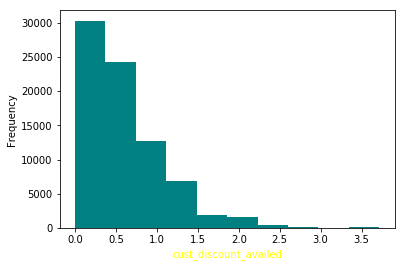

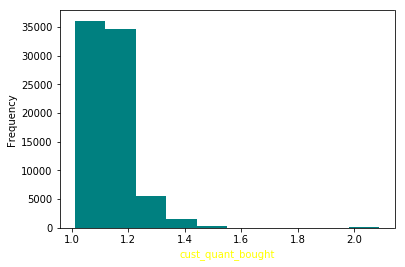

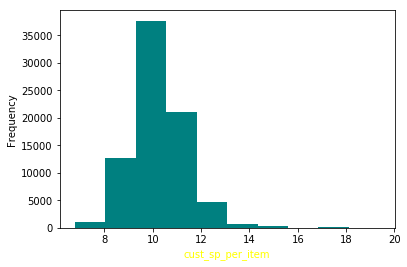

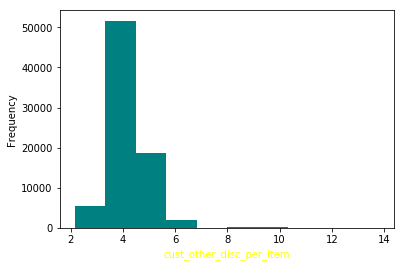

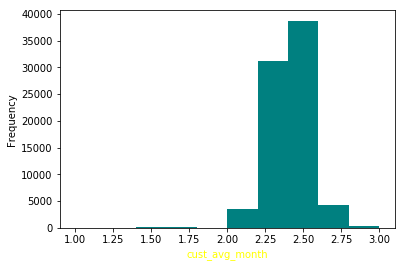

In [27]:
for i in ['cust_discount_availed','cust_quant_bought','cust_sp_per_item',
          'cust_other_disc_per_item','cust_avg_month']:
    train_df[i].plot.hist(color='Teal')
    plt.xlabel(i,color='yellow')
    plt.show()
          

In [28]:
train_df.head()
print(train_df.shape[0])
for i in train_df.columns.drop('redemption_status'):
    print(str(i)+'....',train_df[i].unique().shape[0] ,end='')
    print('               '+str(i)+'....',test_df[i].unique().shape[0])

78369
id.... 78369               id.... 50226
campaign_id.... 18               campaign_id.... 10
coupon_id.... 866               coupon_id.... 331
customer_id.... 1428               customer_id.... 1250
campaign_count.... 7               campaign_count.... 6
coupon_count.... 22               coupon_count.... 14
customer_count.... 30               customer_count.... 24
campaign_type.... 2               campaign_type.... 2
start_date.... 17               start_date.... 8
end_date.... 17               end_date.... 9
campaign_length.... 2               campaign_length.... 2
len_type.... 4               len_type.... 4
age_range.... 7               age_range.... 7
marital_status.... 3               marital_status.... 3
rented.... 2               rented.... 2
family_size.... 5               family_size.... 5
no_of_children.... 4               no_of_children.... 4
income_bracket.... 12               income_bracket.... 12
income_bracket_pp.... 35               income_bracket_pp.... 35
no_of_ad

In [29]:
def cust_disc_cut(df,bins,labels):
    df['cust_most_disc_brand']=pd.cut(df['cust_most_disc_brand'],bins=bins,labels=labels)
    return df
bins=np.int64(np.linspace(-1000,train_df.cust_most_disc_brand.unique().max(),100))
labels=np.int64(np.linspace(-1000,train_df.cust_most_disc_brand.unique().max(),99))
train_df=cust_disc_cut(train_df,bins,labels)
test_df=cust_disc_cut(test_df,bins,labels)
#check_df=cust_disc_cut(check_df,bins,labels)

In [30]:
def cust_quant_cut(df,bins,labels):
    df['cust_quant_bought']=pd.cut(df['cust_quant_bought'],bins=bins,labels=labels)
    return df
bins=np.linspace(1,train_df.cust_quant_bought.unique().max(),400).round(3)
labels=np.linspace(1,train_df.cust_quant_bought.unique().max(),399).round(3)
train_df=cust_quant_cut(train_df,bins,labels)
test_df=cust_quant_cut(test_df,bins,labels)
#check_df=cust_quant_cut(check_df,bins,labels)

In [31]:
train_df.cust_discount_availed.unique()

array([0.54942188, 1.80481082, 1.47331638, ..., 0.90516874, 0.9117996 ,
       0.19445607])

In [32]:
#############################################
def sum_cust_quant_cut(df,bins,labels):
    df['sum_cust_quant_bought']=pd.cut(df['sum_cust_quant_bought'],bins=bins,labels=labels)
    return df
bins=np.int64(np.linspace(75,train_df.sum_cust_quant_bought.unique().max()+1,10))
labels=np.int64(np.linspace(75,train_df.sum_cust_quant_bought.unique().max()+1,9))
train_df=sum_cust_quant_cut(train_df,bins,labels)
test_df=sum_cust_quant_cut(test_df,bins,labels)
#check_df=sum_cust_quant_cut(check_df,bins,labels)
#############################################

In [33]:
def cust_disc_cut(df,bins,labels):
    df['cust_discount_availed']=pd.cut(df['cust_discount_availed'],bins=bins,labels=labels)
    return df
bins = np.linspace(-1,test_df.cust_discount_availed.unique().max()+0.2,300).round(3)
labels = np.linspace(-1,test_df.cust_discount_availed.unique().max()+0.2,299).round(3)
train_df=cust_disc_cut(train_df,bins,labels)
test_df=cust_disc_cut(test_df,bins,labels)
#check_df=cust_disc_cut(check_df,bins,labels)

In [34]:
#################################
def sum_cust_disc_cut(df,bins,labels):
    df['sum_cust_discount_availed']=pd.cut(df['sum_cust_discount_availed'],bins=bins,labels=labels)
    return df
bins=np.int64(np.linspace(-1,train_df.sum_cust_discount_availed.unique().max()+1,10))#30
labels=np.int64(np.linspace(-1,train_df.sum_cust_discount_availed.unique().max()+1,9))
train_df=sum_cust_disc_cut(train_df,bins,labels)
test_df=sum_cust_disc_cut(test_df,bins,labels)
#check_df=sum_cust_disc_cut(check_df,bins,labels)
#################################

In [35]:
def cust_sp_cut(df,bins,labels):
    df['cust_sp_per_item']=pd.cut(df['cust_sp_per_item'],bins=bins,labels=labels)
    return df
bins=np.linspace(6,train_df.cust_sp_per_item.unique().max()+1,400).round(2)
labels=np.linspace(6,train_df.cust_sp_per_item.unique().max()+1,399).round(2)
train_df=cust_sp_cut(train_df,bins,labels)
test_df=cust_sp_cut(test_df,bins,labels)
#check_df=cust_sp_cut(check_df,bins,labels)

In [36]:
######################################
def sum_cust_sp_cut(df,bins,labels):
    df['sum_cust_sp_per_item']=pd.cut(df['sum_cust_sp_per_item'],bins=bins,labels=labels)
    return df
bins=np.int64(np.linspace(7000,train_df.sum_cust_sp_per_item.unique().max()+1,400))
labels=np.int64(np.linspace(7000,train_df.sum_cust_sp_per_item.unique().max()+1,399))
train_df=sum_cust_sp_cut(train_df,bins,labels)
test_df=sum_cust_sp_cut(test_df,bins,labels)
#check_df=sum_cust_sp_cut(check_df,bins,labels)

######################################

In [37]:
def cust_o_d_cut(df,bins,labels):
    df['cust_other_disc_per_item']=pd.cut(df['cust_other_disc_per_item'],bins=bins,labels=labels)
    return df
bins=np.linspace(2,train_df.cust_other_disc_per_item.unique().max(),400).round(2)
labels=np.linspace(2,train_df.cust_other_disc_per_item.unique().max(),399).round(2)
train_df=cust_o_d_cut(train_df,bins,labels)
test_df=cust_o_d_cut(test_df,bins,labels)
#check_df=cust_o_d_cut(check_df,bins,labels)

In [38]:
#####################
def sum_cust_o_d_cut(df,bins,labels):
    df['sum_cust_other_disc_per_item']=pd.cut(df['sum_cust_other_disc_per_item'],bins=bins,labels=labels)
    return df
bins=np.int64(np.linspace(540,train_df.sum_cust_other_disc_per_item.unique().max(),400))
labels=np.int64(np.linspace(540,train_df.sum_cust_other_disc_per_item.unique().max(),399))
train_df=sum_cust_o_d_cut(train_df,bins,labels)
test_df=sum_cust_o_d_cut(test_df,bins,labels)
#check_df=sum_cust_o_d_cut(check_df,bins,labels)
#####################

In [39]:
def coup_disc_cut(df,bins,labels):
    df['mean_disc_per_item_coup']=pd.cut(df['mean_disc_per_item_coup'],bins=bins,labels=labels)
    return df
bins=np.linspace(-1,train_df.mean_disc_per_item_coup.unique().max()+1,50).round(2)
labels=np.linspace(-1,train_df.mean_disc_per_item_coup.unique().max()+1,49).round(2)
train_df=coup_disc_cut(train_df,bins,labels)
test_df=coup_disc_cut(test_df,bins,labels)
#check_df=coup_disc_cut(check_df,bins,labels)

In [40]:
############################
def sum_coup_disc_cut(df,bins,labels):
    df['sum_sum_disc_per_item_coup']=pd.cut(df['sum_sum_disc_per_item_coup'],bins=bins,labels=labels)
    return df
bins=np.int64(np.linspace(-1,train_df.sum_sum_disc_per_item_coup.unique().max()+1,30))
labels=np.int64(np.linspace(-1,train_df.sum_sum_disc_per_item_coup.unique().max()+1,29))
train_df=sum_coup_disc_cut(train_df,bins,labels)
test_df=sum_coup_disc_cut(test_df,bins,labels)
#check_df=sum_coup_disc_cut(check_df,bins,labels)
############################

In [41]:
'''#train_df.mean_quant_per_item_coup.hist()

train_df.describe().round(2)
train_df.loc[train_df.mean_quant_per_item_coup>10000,'mean_quant_per_item_coup'] = 10000
train_df.mean_quant_per_item_coup.hist()
test_df.loc[test_df.mean_quant_per_item_coup>10000,'mean_quant_per_item_coup'] = 10000
test_df.mean_quant_per_item_coup.hist()'''

"#train_df.mean_quant_per_item_coup.hist()\n\ntrain_df.describe().round(2)\ntrain_df.loc[train_df.mean_quant_per_item_coup>10000,'mean_quant_per_item_coup'] = 10000\ntrain_df.mean_quant_per_item_coup.hist()\ntest_df.loc[test_df.mean_quant_per_item_coup>10000,'mean_quant_per_item_coup'] = 10000\ntest_df.mean_quant_per_item_coup.hist()"

In [42]:
def coup_quant_cut(df,bins,labels):
    df['mean_quant_per_item_coup']=pd.cut(df['mean_quant_per_item_coup'],bins=bins,labels=labels)
    return df
bins=np.linspace(0.9,train_df.mean_quant_per_item_coup.unique().max()+1,60).round(2)
labels=np.linspace(0.9,train_df.mean_quant_per_item_coup.unique().max()+1,59).round(2)
train_df=coup_quant_cut(train_df,bins,labels)
test_df=coup_quant_cut(test_df,bins,labels)
#check_df=coup_quant_cut(check_df,bins,labels)

In [43]:
##########################
def sum_coup_quant_cut(df,bins,labels):
    df['sum_sum_quant_per_item_coup']=pd.cut(df['sum_sum_quant_per_item_coup'],bins=bins,labels=labels)
    return df
bins=np.int64(np.linspace(0,train_df.sum_sum_quant_per_item_coup.unique().max()+1,50))
labels=np.int64(np.linspace(0,train_df.sum_sum_quant_per_item_coup.unique().max()+1,49))
train_df=sum_coup_quant_cut(train_df,bins,labels)
test_df=sum_coup_quant_cut(test_df,bins,labels)
#check_df=coup_quant_cut(check_df,bins,labels)
##########################

In [44]:
def coup_sp_cut(df,bins,labels):
    df['mean_sp_per_item_coup']=pd.cut(df['mean_sp_per_item_coup'],bins=bins,labels=labels)
    return df
bins=np.linspace(2,train_df.mean_sp_per_item_coup.unique().max(),60).round(2)
labels=np.linspace(2,train_df.mean_sp_per_item_coup.unique().max(),59).round(2)
train_df=coup_sp_cut(train_df,bins,labels)
test_df=coup_sp_cut(test_df,bins,labels)
#check_df=coup_sp_cut(check_df,bins,labels)

In [45]:
###########################
def sum_coup_sp_cut(df,bins,labels):
    df['sum_sum_sp_per_item_coup']=pd.cut(df['sum_sum_sp_per_item_coup'],bins=bins,labels=labels)
    return df
bins=np.int64(np.linspace(70,train_df.sum_sum_sp_per_item_coup.unique().max()+1,60))
labels=np.int64(np.linspace(70,train_df.sum_sum_sp_per_item_coup.unique().max()+1,59))
train_df=sum_coup_sp_cut(train_df,bins,labels)
test_df=sum_coup_sp_cut(test_df,bins,labels)
#check_df=coup_sp_cut(check_df,bins,labels)
###########################

In [46]:
def coup_o_d_cut(df,bins,labels):
    df['mean_other_disc_per_item_coup']=pd.cut(df['mean_other_disc_per_item_coup'],bins=bins,labels=labels)
    return df
bins=np.linspace(-1,train_df.mean_other_disc_per_item_coup.unique().max(),60).round(2)
labels=np.linspace(-1,train_df.mean_other_disc_per_item_coup.unique().max(),59).round(2)
train_df=coup_o_d_cut(train_df,bins,labels)
test_df=coup_o_d_cut(test_df,bins,labels)
#check_df=coup_o_d_cut(check_df,bins,labels)

In [47]:
###################################
def sum_coup_o_d_cut(df,bins,labels):
    df['sum_sum_other_disc_per_item_coup']=pd.cut(df['sum_sum_other_disc_per_item_coup'],bins=bins,labels=labels)
    return df
bins=np.int64(np.linspace(-1,train_df.sum_sum_other_disc_per_item_coup.unique().max()+1,60))
labels=np.int64(np.linspace(-1,train_df.sum_sum_other_disc_per_item_coup.unique().max()+1,59))
train_df=sum_coup_o_d_cut(train_df,bins,labels)
test_df=sum_coup_o_d_cut(test_df,bins,labels)
#check_df=coup_o_d_cut(check_df,bins,labels)
###################################

In [48]:
train_df.max_brand_coup.value_counts()
def coup_brand_cut(df,bins,labels):
    df['max_brand_coup']=pd.cut(df['max_brand_coup'],bins=bins,labels=labels)
    return df
bins=np.int64(np.linspace(-1,5500,40))#20
labels=np.int64(np.linspace(-1,5500,39))
train_df=coup_brand_cut(train_df,bins,labels)
test_df=coup_brand_cut(test_df,bins,labels)
#check_df=coup_brand_cut(check_df,bins,labels)

In [49]:
train_df.fillna(train_df.max(),inplace=True)
test_df.fillna(test_df.max(),inplace=True)

In [50]:
for i in train_df.columns.drop('redemption_status'):
    a=list(set(train_df[i]).intersection(test_df[i]))
    print(i,len(a),test_df[i].unique().shape[0])


id 0 50226
campaign_id 0 10
coupon_id 81 331
customer_id 1096 1250
campaign_count 5 6
coupon_count 12 14
customer_count 24 24
campaign_type 2 2
start_date 0 8
end_date 0 9
campaign_length 2 2
len_type 4 4
age_range 7 7
marital_status 3 3
rented 2 2
family_size 5 5
no_of_children 4 4
income_bracket 12 12
income_bracket_pp 35 35
no_of_adults 2 2
max_brand_coup 26 28
max_brand_type_coup 2 2
max_category_coup 13 13
max_discount_taken_ever_coup 2 2
max_quant_per_item_coup 91 128
max_disc_per_item_coup 80 126
max_sp_per_item_coup 143 252
max_other_disc_per_item_coup 147 239
max_avg_month_coup 10 10
max_sum_quant_per_item_coup 169 197
max_sum_disc_per_item_coup 99 131
max_sum_sp_per_item_coup 159 306
max_sum_other_disc_per_item_coup 159 284
mean_quant_per_item_coup 10 10
mean_disc_per_item_coup 13 14
mean_sp_per_item_coup 25 28
mean_other_disc_per_item_coup 9 10
mean_avg_month_coup 10 10
sum_sum_quant_per_item_coup 9 10
sum_sum_disc_per_item_coup 8 9
sum_sum_sp_per_item_coup 8 11
sum_sum_othe

## Target Encoding

In [572]:
def target_encoding(df):
    for i in df.columns.drop(['id','campaign_id','customer_id','coupon_id'
                              ,'start_date','end_date']):
        agg_df = train_df.groupby(i)['redemption_status'].agg(['count', 'mean'])
        mean=train_df.redemption_status.mean()
        smooth=(agg_df['count']*agg_df['mean'] + 100 * mean)/(agg_df['count'] + 100)
        df[str(i) + '_scaled'] = df[i].map(smooth)
target_encoding(train_df)
target_encoding(test_df)
#target_encoding(check_df)

In [51]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
def label_encoding(df):
    for i in df.columns.drop(['id','campaign_id','customer_id','coupon_id'
                              ,'start_date','end_date']):
        df[str(i) +'labeled'] = label.fit_transform(df[i].astype('str')) 
label_encoding(train_df)
label_encoding(test_df)
#label_encoding(check_df)

In [41]:
'''def create_dummies(df,column_name):
    dummy_table=pd.get_dummies(df[column_name],prefix='Class'+str(column_name))
    df=pd.concat([df,dummy_table.iloc[:,:-1]],axis=1)
    return df
for i in train_df.columns.drop(['redemption_status','id','campaign_id','customer_id','coupon_id',
                              'start_date','end_date','len_type']):
    train_df=create_dummies(train_df,i)
    test_df=create_dummies(test_df,i)
    check_df=create_dummies(check_df,i)'''

In [667]:
test_df[test_df.isna().any(axis=1)]
train_df.iloc[:,62:]

,campaign_countlabeled,coupon_countlabeled,customer_countlabeled,campaign_typelabeled,campaign_lengthlabeled,len_typelabeled,age_rangelabeled,marital_statuslabeled,rentedlabeled,family_sizelabeled,no_of_childrenlabeled,income_bracketlabeled,income_bracket_pplabeled,no_of_adultslabeled,max_brand_couplabeled,max_brand_type_couplabeled,max_category_couplabeled,max_discount_taken_ever_couplabeled,max_quant_per_item_couplabeled,max_disc_per_item_couplabeled,max_sp_per_item_couplabeled,max_other_disc_per_item_couplabeled,max_avg_month_couplabeled,max_sum_quant_per_item_couplabeled,max_sum_disc_per_item_couplabeled,max_sum_sp_per_item_couplabeled,max_sum_other_disc_per_item_couplabeled,mean_quant_per_item_couplabeled,mean_disc_per_item_couplabeled,mean_sp_per_item_couplabeled,mean_other_disc_per_item_couplabeled,mean_avg_month_couplabeled,sum_sum_quant_per_item_couplabeled,sum_sum_disc_per_item_couplabeled,sum_sum_sp_per_item_couplabeled,sum_sum_other_disc_per_item_couplabeled,cust_discount_availedlabeled,cust_quant_boughtlabeled,cust_sp_per_itemlabeled,cust_other_disc_per_itemlabeled,cust_discount_taken_everlabeled,cust_avg_monthlabeled,sum_cust_discount_availedlabeled,sum_cust_quant_boughtlabeled,sum_cust_sp_per_itemlabeled,sum_cust_other_disc_per_itemlabeled,sum_cust_discount_taken_everlabeled,cust_most_disc_brandlabeled,cust_most_disc_brand_typelabeled,cust_most_disc_categorylabeled,cust_most_disc_coupon_discountlabeled,cust_most_disc_quantitylabeled,cust_most_disc_selling_pricelabeled,cust_most_disc_other_discountlabeled
0,6,17,23,0,1,1,4,2,0,0,0,7,29,0,6,0,3,1,200,207,196,473,3,94,207,63,594,2,1,28,10,7,8,6,6,4,26,83,76,114,1,4,0,1,185,193,1,18,0,4,0,39,332,0
1,6,16,1,0,1,1,3,1,0,1,0,5,11,1,0,1,3,0,77,0,465,56,10,280,0,454,502,1,0,19,0,7,0,0,11,0,90,68,98,95,1,4,4,1,221,3,1,14,0,4,0,2,174,0
2,3,20,4,1,0,2,4,1,0,1,0,9,25,1,14,0,8,1,200,207,491,456,3,14,59,299,194,3,8,13,4,7,0,0,11,0,77,59,27,59,1,5,4,1,14,31,1,15,0,5,0,0,10,0
3,6,17,27,0,1,1,0,0,1,4,3,3,16,1,24,0,3,1,110,130,42,34,9,137,52,241,251,1,13,34,0,7,0,0,11,0,44,43,172,55,1,6,2,1,104,120,1,14,0,5,0,33,428,0
4,6,17,26,0,1,1,4,1,0,1,0,5,11,1,6,0,3,1,118,61,252,369,2,163,5,465,39,1,0,5,7,7,0,0,6,0,35,106,7,70,1,6,2,1,192,5,1,18,0,0,0,11,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78364,6,17,25,0,1,1,6,1,0,1,0,0,3,1,0,1,3,0,124,0,457,181,8,81,0,645,322,2,0,19,2,6,0,0,11,0,0,4,20,19,0,6,0,1,189,128,0,17,0,5,0,37,550,0
78365,4,1,28,0,1,1,6,1,0,1,0,4,7,1,10,0,3,1,141,5,286,113,11,226,136,627,207,1,0,5,14,6,0,0,11,0,28,29,157,51,1,5,0,1,104,120,1,15,0,6,0,37,285,0
78366,6,6,28,0,1,1,0,0,1,4,3,3,16,1,26,0,3,1,94,166,193,25,3,28,199,131,592,1,8,1,11,6,0,6,11,2,17,32,1,46,1,4,2,1,75,70,1,18,0,5,0,0,206,0
78367,6,16,2,0,1,1,3,1,0,4,3,6,6,1,0,1,3,0,27,0,341,32,2,175,0,607,33,0,0,8,0,6,0,0,11,0,61,53,153,78,1,6,4,1,212,49,1,17,0,5,0,39,387,0


## Modelling

In [52]:
features = train_df.iloc[:,62:].columns
train_df1 = train_df[features]
train_X,test_X,train_y,test_y = train_test_split(train_df1,train_df.redemption_status,
                                              test_size=0.2,random_state=45)

In [ ]:
from imblearn.combine import SMOTETomek
rs = SMOTETomek(random_state=78)
train_X,train_y = rs.fit_sample(train_df[features],train.redemption_status)

In [52]:
rfc=RandomForestClassifier(n_estimators=100, 
                                 min_samples_split=2, 
                                 min_samples_leaf=1, 
                                 max_features=0.2,
                                 max_depth=6, 
                                 bootstrap=True)
rfc.fit(train_df1,train_df.redemption_status)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features=0.2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [1252]:
check_df[check_df.isna().any(axis=1)]
check_df.fillna(check_df.max(),inplace=True)

In [1254]:
print('train:{}'.format(roc_auc_score(train_df.redemption_status,rfc.predict_proba(train_df1[features])[:,1])))
print('check:{}'.format(roc_auc_score(check_df.redemption_status,rfc.predict_proba(check_df[features])[:,1])))

train:0.9558197238244143
check:0.8601155943478065


In [520]:
colormap = plt.cm.RdBu
plt.figure(figsize=(15,15))
x = train_df1
x['redemption_status'] = train_df.redemption_status
#sns.heatmap(x.iloc[:,20:50].corr(),linewidths=0.1,vmax=1.0, 
 #           square=True, cmap=colormap, linecolor='white', annot=True)
new_features = features.drop(['campaign_lengthlabeled','len_typelabeled','marital_statuslabeled',
               'rentedlabeled','max_discount_taken_ever_couplabeled',
               'cust_discount_taken_everlabeled','sum_cust_discount_taken_everlabeled',])
              

<Figure size 1080x1080 with 0 Axes>

In [54]:
f_dict = {'features':[],'importance':[]}
for col,imp in zip(features,cb.feature_importances_):
    f_dict['features'].append(col)
    f_dict['importance'].append(imp)
feat_df = pd.DataFrame(data=f_dict)
feat_df.sort_values('importance',ascending=False)

,features,importance
36,cust_discount_availedlabeled,9.015189
24,max_sum_disc_per_item_couplabeled,7.498711
42,sum_cust_discount_availedlabeled,7.468287
19,max_disc_per_item_couplabeled,5.367594
46,sum_cust_discount_taken_everlabeled,4.656137
44,sum_cust_sp_per_itemlabeled,4.059606
52,cust_most_disc_selling_pricelabeled,3.376728
18,max_quant_per_item_couplabeled,2.799669
38,cust_sp_per_itemlabeled,2.764943
20,max_sp_per_item_couplabeled,2.517318


In [70]:
imp_features = feat_df.sort_values('importance',ascending=False).features[:25]
print(len(features),len(imp_features))
imp_features

54 25


36           cust_discount_availedlabeled
24      max_sum_disc_per_item_couplabeled
42       sum_cust_discount_availedlabeled
19          max_disc_per_item_couplabeled
46    sum_cust_discount_taken_everlabeled
44            sum_cust_sp_per_itemlabeled
52    cust_most_disc_selling_pricelabeled
18         max_quant_per_item_couplabeled
38                cust_sp_per_itemlabeled
20            max_sp_per_item_couplabeled
37               cust_quant_boughtlabeled
22              max_avg_month_couplabeled
45    sum_cust_other_disc_per_itemlabeled
39        cust_other_disc_per_itemlabeled
0                   campaign_countlabeled
11                  income_bracketlabeled
12               income_bracket_pplabeled
51         cust_most_disc_quantitylabeled
2                   customer_countlabeled
6                        age_rangelabeled
23     max_sum_quant_per_item_couplabeled
17    max_discount_taken_ever_couplabeled
25        max_sum_sp_per_item_couplabeled
14                  max_brand_coup

In [72]:
test_df.fillna(train_df.max(),inplace=True)
from scipy.special import logit
from imblearn.under_sampling import TomekLinks
#from sklearn.linear_model import LogisticRegression
bc = TomekLinks(random_state=547)
#bc.fit(train_df1,train_df.redemption_status)
#train_X_rs,train_y_rs=bc.fit_sample(train_X,train_y)
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
train_scores,val_scores=[],[]
predictions=[]
predictions_train=[]
camp_list = [[1,13,2,25],[26,6,29,30],[0,8,0,0],[12,11,9,29],
             [9,10,29,30],[1,2,8,4],[13,5,6,7],[6,7,26,30]]
for i in camp_list :
    val_set=train_df[(train_df.campaign_id==i[0])|(train_df.campaign_id==i[1])|
                        (train_df.campaign_id==i[2])|(train_df.campaign_id==i[3])]
    
    train_set=train_df[~((train_df.campaign_id==i[0])|(train_df.campaign_id==i[1])|
                            (train_df.campaign_id==i[2])|(train_df.campaign_id==i[3]))]
    
    train_X,train_y = train_set[features],train_set.redemption_status
    val_X,val_y = val_set[features],val_set.redemption_status
        
    
    #train_X,train_y=bc.fit_sample(train_X,train_y)
    
    cb = CatBoostClassifier(
            iterations=500,
            learning_rate=0.03,
            random_strength=0.9,
            depth=9,
            loss_function='CrossEntropy',
            eval_metric='AUC',
            metric_period = 100,  
            leaf_estimation_method='Newton')
            #l2_leaf_reg=12.5)
    cb.fit(train_X, train_y,
                     eval_set=(val_X,val_y),
                     #cat_features=categorical_var,
                     use_best_model=True,
                     verbose=True)
    train_scores.append(roc_auc_score(train_y,(cb.predict_proba(train_X)[:,-1])))
    print('train : {}'.format(roc_auc_score(train_y,(cb.predict_proba(train_X)[:,-1]))))
    pred_val = (cb.predict_proba(val_X)[:,-1])
    #pred_val[pred_val>0.7] =1
    val_scores.append(roc_auc_score(val_y,pred_val))
    print('val : {}'.format(roc_auc_score(val_y,pred_val)))
    pred_test = (cb.predict_proba(test_df[features])[:,-1])
    #pred_test[pred_test>0.7] =1
    predictions.append(pred_test)
    predictions_train.append((cb.predict_proba(train_df[features])))
print('train score: {}'.format(np.array(train_scores).mean().round(3))
      ,'val score: {}'.format(np.array(val_scores).mean().round(3)))

0:	test: 0.6836647	best: 0.6836647 (0)	total: 145ms	remaining: 1m 12s
100:	test: 0.8900734	best: 0.8900734 (100)	total: 12.1s	remaining: 47.7s
200:	test: 0.9002962	best: 0.9002962 (200)	total: 24.1s	remaining: 35.8s
300:	test: 0.9036729	best: 0.9036729 (300)	total: 35.8s	remaining: 23.7s
400:	test: 0.9026276	best: 0.9036729 (300)	total: 47.6s	remaining: 11.8s
499:	test: 0.9021999	best: 0.9036729 (300)	total: 59.2s	remaining: 0us

bestTest = 0.9036728852
bestIteration = 300

Shrink model to first 301 iterations.
train : 0.9953788940245871
val : 0.9036728852304613
0:	test: 0.6650249	best: 0.6650249 (0)	total: 135ms	remaining: 1m 7s
100:	test: 0.8689341	best: 0.8689341 (100)	total: 12.6s	remaining: 49.8s
200:	test: 0.8709386	best: 0.8709386 (200)	total: 24.9s	remaining: 37s
300:	test: 0.8756353	best: 0.8756353 (300)	total: 37.1s	remaining: 24.5s
400:	test: 0.8763381	best: 0.8763381 (400)	total: 49.3s	remaining: 12.2s
499:	test: 0.8760831	best: 0.8763381 (400)	total: 1m 2s	remaining: 0us



In [303]:
#pred_val[pred_val>0.7] =0.9
pred_val[pred_val>0.7]

array([0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9])

In [290]:
pd.set_option('display.max_rows',100)
#val_X['predicted'] = cb.predict_proba(val_X)[:,1]
val_X['actual'] = val_y
val_X[val_X.predicted<0.0]

,campaign_count_scaled,coupon_count_scaled,customer_count_scaled,campaign_type_scaled,age_range_scaled,family_size_scaled,no_of_children_scaled,income_bracket_scaled,income_bracket_pp_scaled,no_of_adults_scaled,max_brand_coup_scaled,max_brand_type_coup_scaled,max_category_coup_scaled,mean_quant_per_item_coup_scaled,mean_disc_per_item_coup_scaled,mean_sp_per_item_coup_scaled,mean_other_disc_per_item_coup_scaled,mean_avg_month_coup_scaled,sum_sum_quant_per_item_coup_scaled,sum_sum_disc_per_item_coup_scaled,sum_sum_sp_per_item_coup_scaled,sum_sum_other_disc_per_item_coup_scaled,cust_discount_availed_scaled,cust_quant_bought_scaled,cust_sp_per_item_scaled,cust_other_disc_per_item_scaled,cust_avg_month_scaled,sum_cust_discount_availed_scaled,sum_cust_quant_bought_scaled,sum_cust_sp_per_item_scaled,sum_cust_other_disc_per_item_scaled,cust_most_disc_brand_scaled,cust_most_disc_brand_type_scaled,cust_most_disc_category_scaled,predicted,actual


In [69]:
from xgboost import XGBClassifier
from imblearn.under_sampling import TomekLinks
#from sklearn.linear_model import LogisticRegression
bc = TomekLinks(random_state=547)
#bc.fit(train_df1,train_df.redemption_status)
#train_X_rs,train_y_rs=bc.fit_sample(train_X,train_y)
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
train_scores,val_scores=[],[]
predictions=[]
predictions_train=[]
camp_list = [[1,13,2,25],[26,6,29,30],[0,8,0,0],[12,11,9,29],
             [9,10,29,30],[1,2,8,4],[13,5,6,7],[6,7,26,30]]
for i in camp_list[:1] :
    val_set=train_df[(train_df.campaign_id==i[0])|(train_df.campaign_id==i[1])|
                        (train_df.campaign_id==i[2])|(train_df.campaign_id==i[3])]
    
    train_set=train_df[~((train_df.campaign_id==i[0])|(train_df.campaign_id==i[1])|
                            (train_df.campaign_id==i[2])|(train_df.campaign_id==i[3]))]
    
    train_X,train_y = train_set[features],train_set.redemption_status
    val_X,val_y = val_set[features],val_set.redemption_status
        
    
    #train_X,train_y=bc.fit_sample(train_X,train_y)
    
    xg=LogisticRegression(max_iter=100,C=0.5)
    xg.fit(train_X, train_y)
    train_scores.append(roc_auc_score(train_y,xg.predict_proba(train_X)[:,-1]))
    print('train : {}'.format(roc_auc_score(train_y,xg.predict_proba(train_X)[:,-1])))
    val_scores.append(roc_auc_score(val_y,xg.predict_proba(val_X)[:,-1]))
    print('val : {}'.format(roc_auc_score(val_y,xg.predict_proba(val_X)[:,-1])))
    predictions.append(xg.predict_proba(test_df[features])[:,-1])
    predictions_train.append(xg.predict_proba(train_df[features]))
print('train score: {}'.format(np.array(train_scores).mean().round(3))
      ,'val score: {}'.format(np.array(val_scores).mean().round(3)))

train : 0.9119098995353525
val : 0.8971222995114101
train score: 0.912 val score: 0.897


In [112]:
print('train:{}'.format(roc_auc_score(train_df.redemption_status,cb.predict_proba(train_df1[features])[:,1])))
#print('check:{}'.format(roc_auc_score(check_df.redemption_status,cb.predict_proba(check_df[features])[:,1])))

train:0.9483667187518773


In [47]:
test_df[features][test_df[features].isna().any(axis=1)]

,campaign_count_scaled,customer_count_scaled,campaign_type_scaled,campaign_length_scaled,len_type_scaled,age_range_scaled,marital_status_scaled,rented_scaled,family_size_scaled,no_of_children_scaled,income_bracket_scaled,income_bracket_pp_scaled,no_of_adults_scaled,max_brand_coup_scaled,max_brand_type_coup_scaled,max_category_coup_scaled,max_discount_taken_ever_coup_scaled,mean_quant_per_item_coup_scaled,mean_disc_per_item_coup_scaled,mean_sp_per_item_coup_scaled,mean_other_disc_per_item_coup_scaled,mean_avg_month_coup_scaled,cust_discount_availed_scaled,cust_quant_bought_scaled,cust_sp_per_item_scaled,cust_other_disc_per_item_scaled,cust_discount_taken_ever_scaled,cus_discount_taken_ever_scaled,cust_avg_month_scaled,cust_most_disc_brand_scaled,cust_most_disc_brand_type_scaled,cust_most_disc_category_scaled
23,NaN,0.008836,0.004519,0.005922,0.004957,0.008745,0.013796,0.013087,0.012828,0.012352,0.019966,0.013406,0.013017,0.001416,0.010605,0.001382,0.000037,0.009324,0.000037,0.006004,0.017950,0.013692,0.000670,0.016719,0.003380,0.020886,0.011057,0.011057,0.003045,0.002224,0.008460,0.002158
42,NaN,0.007677,0.004519,0.005922,0.004957,0.014418,0.013796,0.013087,0.012828,0.012352,0.010385,0.012249,0.013017,0.012386,0.010605,0.002957,0.013590,0.007304,0.014583,0.016074,0.007323,0.013692,0.003486,0.007185,0.008473,0.022458,0.011057,0.011057,0.010146,0.013384,0.008460,0.012954
43,NaN,0.007629,0.004519,0.005922,0.004957,0.014418,0.011763,0.013087,0.012466,0.012352,0.006997,0.009840,0.012946,0.013547,0.010605,0.002957,0.013590,0.008455,0.019797,0.004318,0.010484,0.013692,0.006288,0.010850,0.013565,0.003471,0.011057,0.011057,0.010146,0.004943,0.008460,0.012954
47,NaN,0.007497,0.004519,0.005922,0.004957,0.013060,0.013796,0.013087,0.009884,0.012188,0.008690,0.003565,0.013017,0.002067,0.004959,0.027484,0.000037,0.009324,0.000037,0.007438,0.011318,0.006917,0.010983,0.004085,0.003075,0.003685,0.011057,0.011057,0.010315,0.033419,0.024702,0.012954
59,0.012062,0.006361,0.011023,0.010683,0.011308,0.013256,0.011763,0.013087,0.012466,0.012352,0.019966,0.019756,0.012946,0.002067,0.004959,0.010467,0.000037,0.009324,0.000037,0.012936,0.005368,0.006917,0.009656,0.002827,0.003011,NaN,0.011057,0.011057,0.010146,0.001902,0.008460,0.002158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50126,0.005575,0.005740,0.004519,0.005922,0.004957,0.013256,0.013796,0.013087,0.009884,0.012188,0.015069,0.013406,0.013017,0.016840,0.010605,0.017310,0.013590,0.009324,0.011116,0.019375,0.007707,0.013692,0.001925,0.005220,NaN,0.001775,0.011057,0.011057,0.010146,0.001902,0.024702,0.012954
50137,0.012062,0.008836,0.011023,0.010683,0.011308,0.014418,0.011763,0.013087,0.012466,0.012352,0.019658,0.016891,0.012946,0.014342,0.010605,0.010467,0.013590,0.009324,0.014583,0.006004,0.011120,0.013692,0.009620,NaN,0.016720,0.002432,0.011057,0.011057,0.010315,0.001111,0.008460,0.002158
50148,NaN,0.007629,0.004519,0.005922,0.004957,0.014418,0.013796,0.013087,0.012828,0.012352,0.019658,0.021794,0.013017,0.010711,0.010605,0.002957,0.013590,0.015040,0.011285,0.005590,0.013285,0.006917,0.014019,0.004975,0.023587,0.006656,0.011057,0.011057,0.010315,0.026686,0.024702,0.012954
50171,0.012062,0.004682,0.011023,0.010683,0.011308,0.004652,0.004652,0.004652,0.004652,0.004652,0.004652,0.004652,0.004652,0.002067,0.004959,0.010467,0.000037,0.007304,0.000037,0.003436,0.011120,0.003050,0.004534,0.007073,0.009001,NaN,0.011057,0.011057,0.002628,0.002224,0.008460,0.012954


## Grid Search

In [ ]:
params = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200],
          'ctr_border_count':[50,5,10,20,100,200],
          'thread_count':4}

In [ ]:
def crossvaltest(params,train_set,train_label,cat_dims,n_splits=3):
    kf = KFold(n_splits=n_splits,shuffle=True) 
    res = []
    camp_list = [[1,13,2,25],[26,6,29,30],[0,8,0,0],[12,11,9,29],
             [9,10,29,30],[1,2,8,4],[13,5,6,7],[6,7,26,30]]
    for i in camp_list[:1] :
        val_set=train_df[(train_df.campaign_id==i[0])|(train_df.campaign_id==i[1])|
                            (train_df.campaign_id==i[2])|(train_df.campaign_id==i[3])]

        train_set=train_df[~((train_df.campaign_id==i[0])|(train_df.campaign_id==i[1])|
                                (train_df.campaign_id==i[2])|(train_df.campaign_id==i[3]))]

        train_X,train_y = train_set[imp_features],train_set.redemption_status
        val_X,val_y = val_set[imp_features],val_set.redemption_status


        clf = cb.CatBoostClassifier(**params)
        clf.fit(train_X, train_y, eval_set=(val_X,val_y))

        res.append(np.mean(clf.predict(test)==np.ravel(test_labels)))
    return np.mean(res)

In [ ]:
def catboost_param_tune(params,train_set,train_label,cat_dims=None,n_splits=3):
    ps = paramsearch(params)
    # search 'border_count', 'l2_leaf_reg' etc. individually 
    #   but 'iterations','learning_rate' together
    for prms in chain(ps.grid_search(['border_count']),
                      ps.grid_search(['ctr_border_count']),
                      ps.grid_search(['l2_leaf_reg']),
                      ps.grid_search(['iterations','learning_rate']),
                      ps.grid_search(['depth'])):
        res = crossvaltest(prms,train_set,train_label,cat_dims,n_splits)
        # save the crossvalidation result so that future iterations can reuse the best parameters
        ps.register_result(res,prms)
        print(res,prms,s'best:',ps.bestscore(),ps.bestparam())
    return ps.bestparam()

bestparams = catboost_param_tune(params,train_set,train_label,cat_dims)

## Submission

In [84]:
mean_pred = np.mean(predictions,0)
mean_pred[mean_pred>0.7]=0.95
mean_pred[mean_pred<0.1] = 0.001

In [83]:
len(mean_pred[mean_pred<0.001])

19342

In [132]:
holdout = lr.predict_proba(pred_test_df)[:,1]

In [254]:
test_df.fillna(test_df.max(),inplace=True)

In [255]:
holdout = cb.predict_proba(test_df[features])[:,-1]
#holdout = mean_pred

In [85]:
sub_dict = {'id' : test_df['id'],
           'redemption_status' : mean_pred}
sub_df = pd.DataFrame(data=sub_dict)
sub_df.to_csv('Submission.csv',index=False)